In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pathlib
import tensorflow as tf
import cv2, os, random
import graphviz
import time
from termcolor import colored
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow.keras import layers, losses, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#____________________________________________________________

from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)
#____________________________________________________________


dir = "A:/BSCS/P/Dataset/training/"

path_for_data = pathlib.Path(dir)

#____________________________________________________________

print(colored("Required libraries were succesfully imported...", color = "blue", attrs = ["bold", "dark"]))


Required libraries were succesfully imported...


In [2]:

train_df = image_dataset_from_directory(path_for_data,
                                        image_size = (128, 128),
                                        validation_split = 0.2,
                                        subset = "training",
                                        shuffle = True,
                                        batch_size = 32,
                                        seed = 123)

Found 13868 files belonging to 42 classes.
Using 11095 files for training.


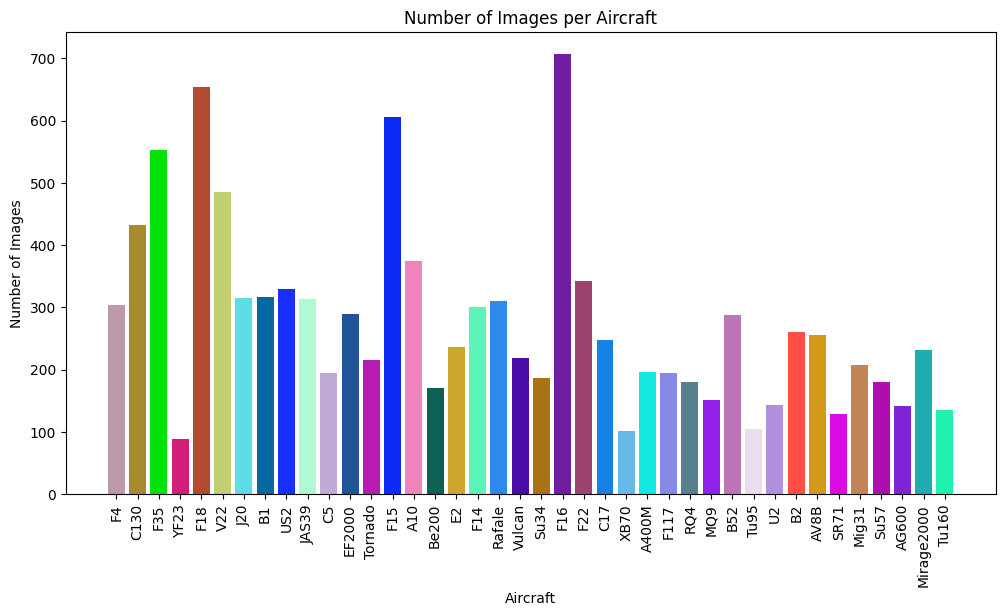

In [3]:
import random
class_names =train_df.class_names

# Generate random colors for each aircraft class
class_colors = ['#' + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in range(40)]

# Count the number of images per class
class_counts = {}
for images, labels in train_df:
    for label in labels.numpy():
        class_name = class_names[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

# Plot the histogram with colored bars
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Aircraft')
plt.ylabel('Number of Images')
plt.title('Number of Images per Aircraft')
plt.xticks(rotation=90)
plt.show()




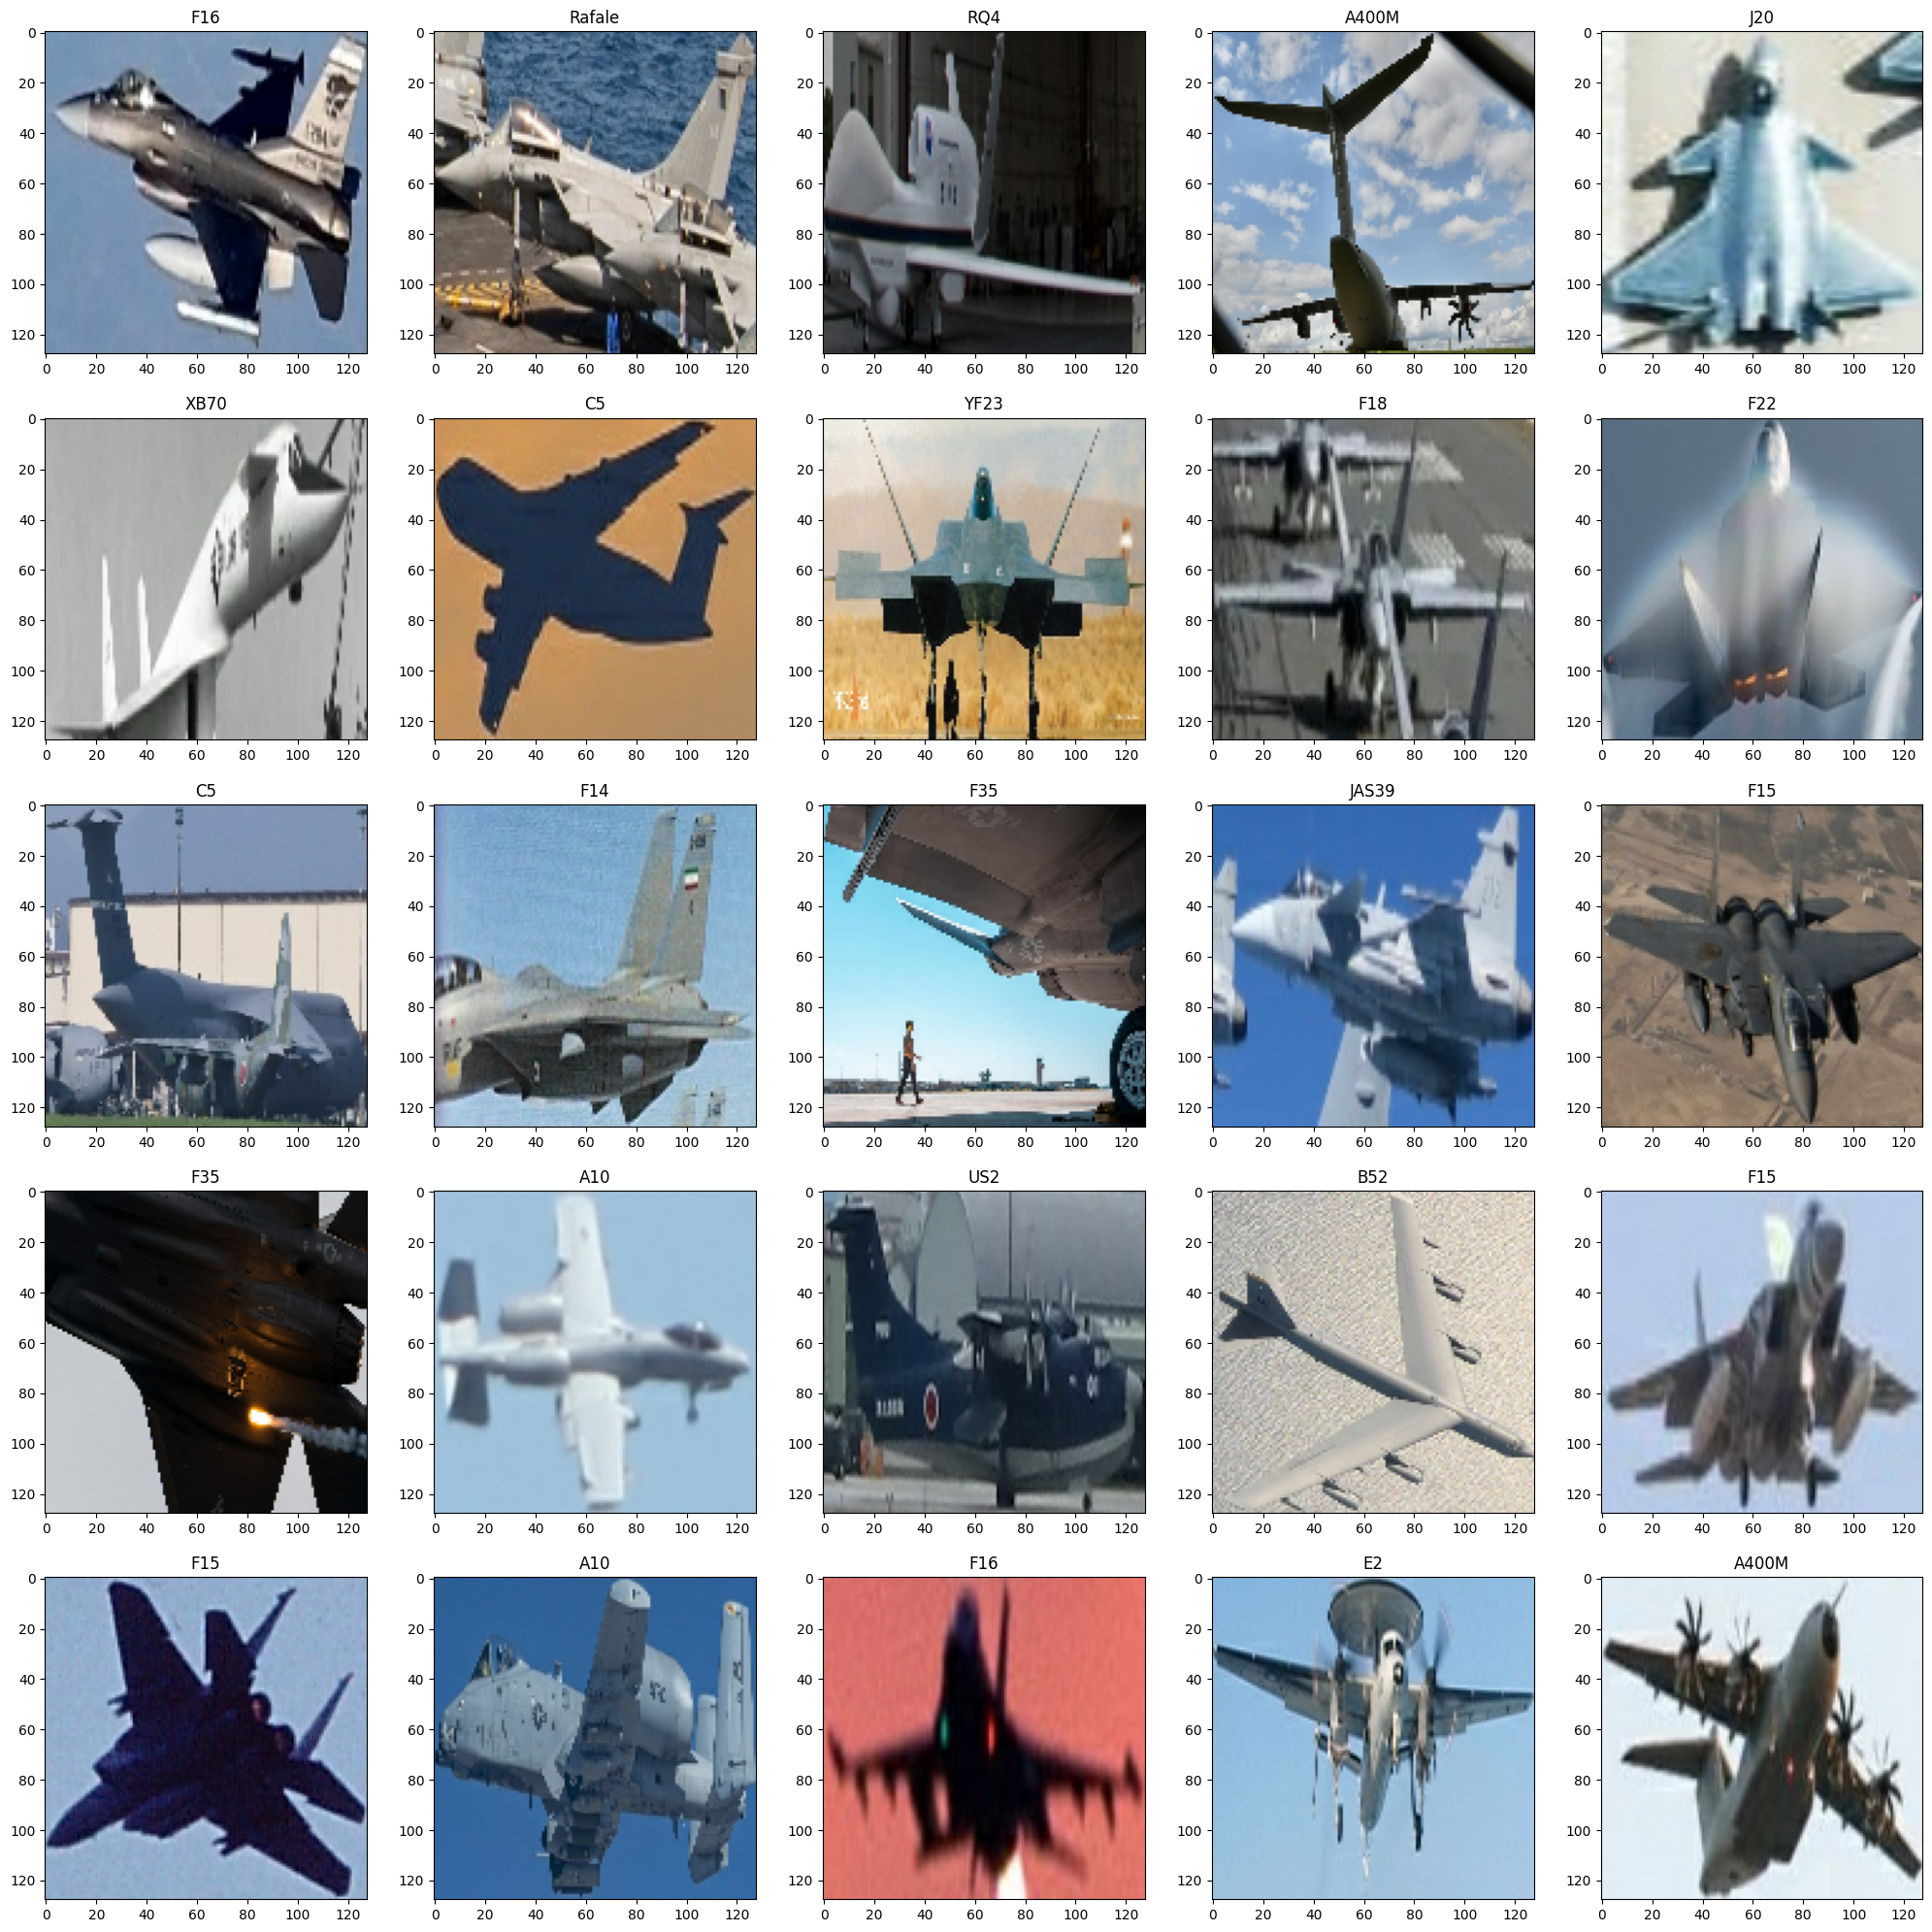

In [4]:
plt.figure(figsize = (25, 25))
for images, labels in train_df.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

In [5]:
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [6]:
img_size = (224, 224)
batch_size = 32

train_df = data_augmentation.flow_from_directory(
    path_for_data,
    target_size=img_size,
    batch_size=32,
    shuffle=True,
    class_mode='sparse',
    seed=123,
    subset='training'
)

validation_df = data_augmentation.flow_from_directory(
    path_for_data,
    target_size=img_size,
    batch_size=32,
    shuffle=False,
    class_mode='sparse',
    seed=123,
    subset='validation'
)

Found 11107 images belonging to 42 classes.
Found 2761 images belonging to 42 classes.


In [7]:
train_df, validation_df

(<keras.src.legacy.preprocessing.image.DirectoryIterator at 0x193b7ebb080>,
 <keras.src.legacy.preprocessing.image.DirectoryIterator at 0x193a21fb830>)

In [8]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 348 images in the training dataset
There is 87 images in the validation dataset


In [9]:
# Calculate the number of batches for the test set
test_batches = validation_df.n // 10

# Create a new generator for the test set
test_df = data_augmentation.flow_from_directory(
    path_for_data,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=123,
    subset='validation',
    shuffle=False
)

# Skip the first (test_batches) batches for the validation set
for _ in range(test_batches):
    next(validation_df)

Found 2761 images belonging to 42 classes.


In [10]:
class_indices = train_df.class_indices
class_names = list(class_indices.keys())
plane_details = {
    class_names[0]: "Generation: 4th\nType: Attack Aircraft\nMax Speed: 0.56\nArmaments: Yes",
    class_names[1]: "Generation: 4th \nType: Transport Aircraft\nMax Speed: 0.72\nArmaments: No",
    class_names[2]: "Generation: N/A\nType: Amphibious Aircraft\nMax Speed: 0.46\nArmaments: No",
    class_names[3]: "Generation: 2nd \nType: Attack Aircraft\nMax Speed: 0.9\nArmaments: Yes",
    class_names[4]: "Generation: 4th \nType: Bomber\nMax Speed: 1.25\nArmaments: Yes",
    class_names[5]: "Generation: 5th \nType: Stealth Bomber\nMax Speed: 0.95\nArmaments: Yes",
    class_names[6]: "Generation: 2nd \nType: Bomber\nMax Speed: 0.86\nArmaments: Yes",
    class_names[7]: "Generation: N/A \nType: Amphibious Aircraft\nMax Speed: 0.64\nArmaments: No",
    class_names[8]: "Generation: 2nd \nType: Transport Aircraft\nMax Speed: 0.58\nArmaments: No",
    class_names[9]: "Generation: 4th \nType: Transport Aircraft\nMax Speed: 0.74\nArmaments: No",
    class_names[10]: "Generation: 2nd \nType: Transport Aircraft\nMax Speed: 0.75\nArmaments: No",
    class_names[11]: "Generation: 2nd \nType: Early Warning\nMax Speed: 0.6\nArmaments: No",
    class_names[12]: "Generation: 4th \nType: Multirole Fighter\nMax Speed: 2\nArmaments: Yes\n",
    class_names[13]: "Generation: 3rd \nType: Fighter\nMax Speed: 2.23\nArmaments: Yes",
    class_names[14]: "Generation: 4th \nType: Fighter\nMax Speed: 2.34\nArmaments: Yes",
    class_names[15]: "Generation: 4th \nType: Fighter\nMax Speed: 2.5\nArmaments: Yes",
    class_names[16]: "Generation: 4th \nType: Multirole Fighter\nMax Speed: 2\nArmaments: Yes",
    class_names[17]: "Generation: 4th \nType: Multirole Fighter\nMax Speed: 1.8\nArmaments: Yes",
    class_names[18]: "Generation: 5th \nType: Stealth Multirole\nMax Speed: 2.25\nArmaments: Yes",
    class_names[19]: "Generation: 5th \nType: Stealth Multirole\nMax Speed: 1.6\nArmaments: Yes",
    class_names[20]: "Generation: 4th \nType: Stealth Attack\nMax Speed: .92\nArmaments: Yes",
    class_names[21]: "Generation: 5th \nType: Stealth Fighter\nMax Speed: 2\nArmaments: Yes",
    class_names[22]: "Generation: 4th \nType:Multirole Fighter \nMax Speed: 2.2\nArmaments: Yes",
    class_names[23]: "Generation: N/A \nType: UAV\nMax Speed: 0.45\nArmaments: Yes",
    class_names[24]: "Generation: 4th \nType: Interceptor \nMax Speed: 2.35\nArmaments: Yes",
    class_names[25]: "Generation: 4th \nType: Multirole Fighter\nMax Speed: 2.2\nArmaments: Yes",
    class_names[26]: "Generation: N/A \nType: UAV\nMax Speed: 0.6 \nArmaments: No",
    class_names[27]: "Generation: 4th \nType: Multirole Fighter \nMax Speed: 1.8\nArmaments: Yes",
    class_names[28]: "Generation: 3rd \nType: Reconnaissance\nMax Speed: 3.3\nArmaments: No",
    class_names[29]: "Generation: 4th \nType: Fighter Bomber\nMax Speed: 1.8\nArmaments: Yes",
    class_names[30]: "Generation: 5th \nType: Stealth Fighter \nMax Speed: 2\nArmaments: Yes",
    class_names[31]: "Generation: 4th \nType: Multirole Fighter\nMax Speed: 1.3\nArmaments: Yes",
    class_names[32]: "Generation: 2nd \nType: Bomber\nMax Speed: 0.83\nArmaments: Yes",
    class_names[33]: "Generation: 4th \nType: Bomber\nMax Speed: 2.05\nArmaments: Yes",
    class_names[34]: "Generation: N/A \nType: Reconnaissance\nMax Speed: 0.67\nArmaments: No",
    class_names[35]: "Generation: N/A \nType: Amphibious Aircraft\nMax Speed: 0.49\nArmaments: No",
    class_names[36]: "Generation: N/A \nType: Tiltrotor\nMax Speed: 0.6\nArmaments: Yes",
    class_names[37]: "Generation: 2nd \nType: Bomber\nMax Speed: 0.96\nArmaments: Yes",
    class_names[38]: "Generation: 3rd \nType: Bomber\nMax Speed: 3.1\nArmaments: No",
    class_names[39]: "Generation: 4th \nType: Stealth Fighter\nMax Speed: 1.8\nArmaments: Yes",
    
}

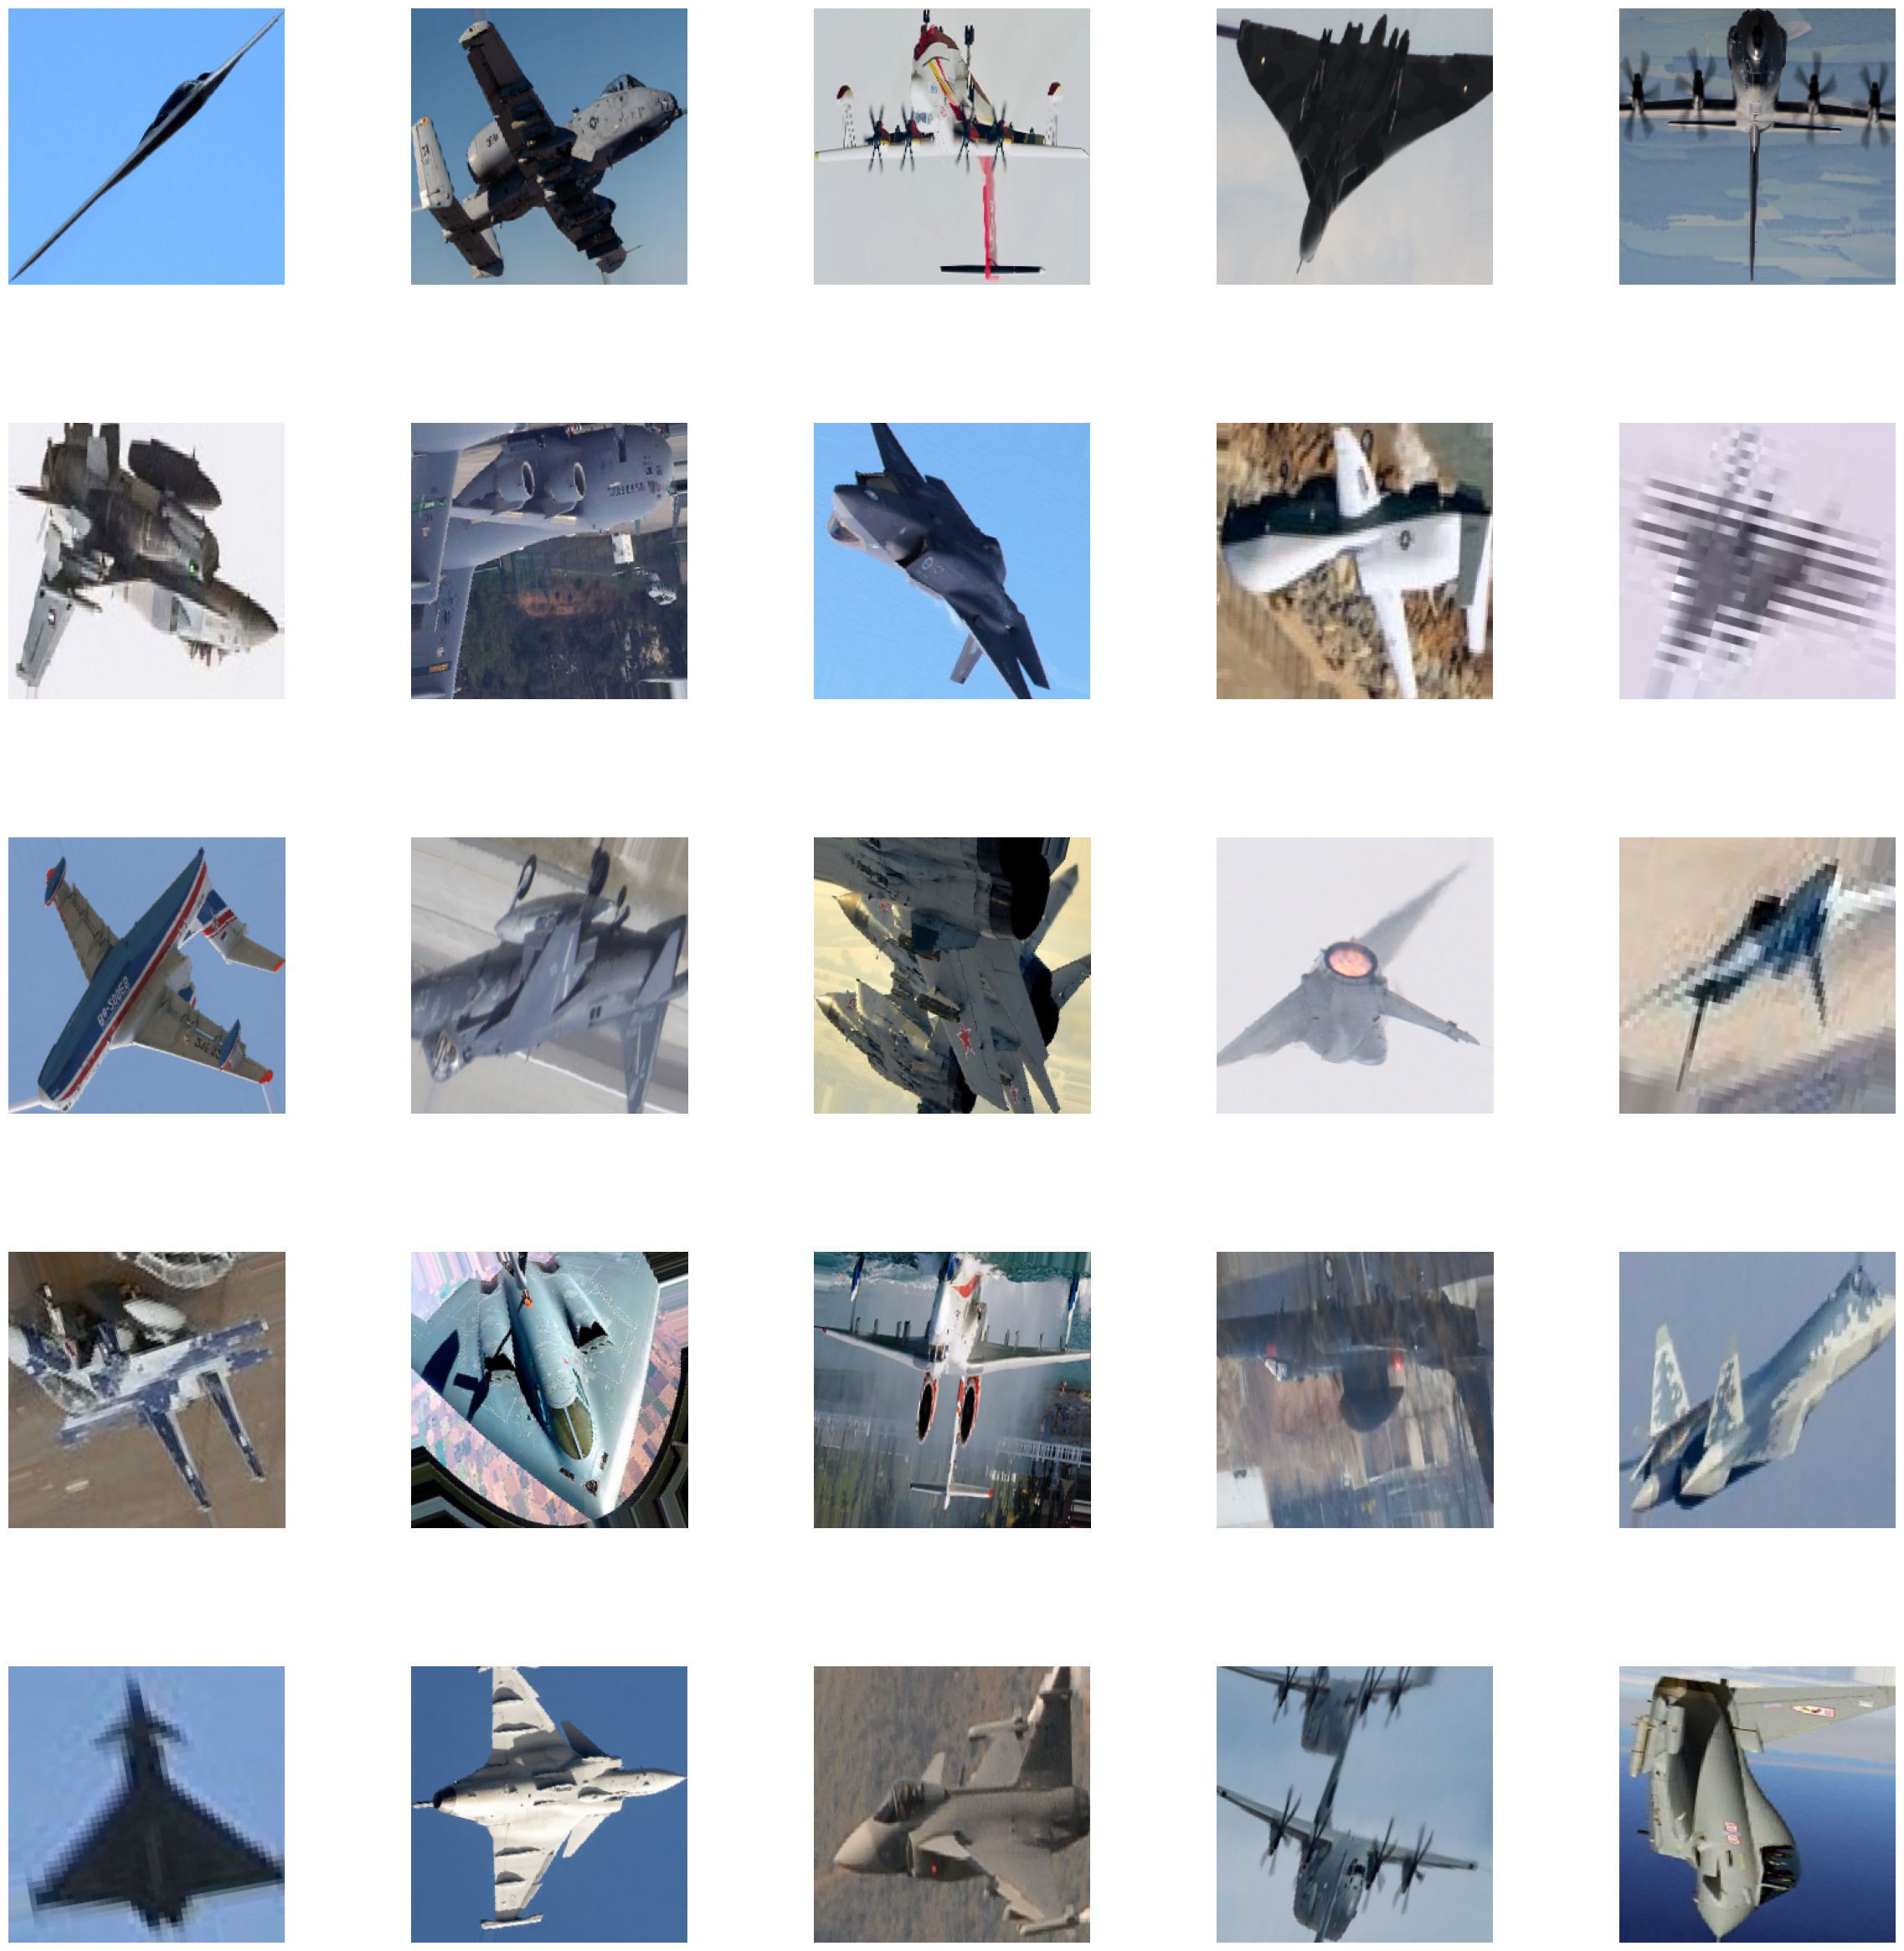

In [11]:
import numpy as np

def display_images_and_labels(dataset, class_names, plane_details):
    plt.figure(figsize=(30, 30))
    num_images_displayed = 0
    
    for images, labels in dataset:
        for i in range(len(images)):
            if num_images_displayed >= 25:
                break

            ax = plt.subplot(5, 5, num_images_displayed + 1)
            plt.imshow(images[i].astype(np.uint8))
            plane_name = class_names[np.argmax(labels[i])]
            plt.title(f"", 
                      fontweight='bold' if '\n' not in plane_name else 'normal', 
                      fontsize=14, pad=20)
            plt.axis("off")
            num_images_displayed += 1

        if num_images_displayed >= 25:
            break

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

# Display images and labels from the training dataset
display_images_and_labels(train_df, class_names, plane_details)



In [12]:
img_shape = img_size + (3,)
class_count = len(class_names)
preprocess_input = efficientnet.preprocess_input

base_model = efficientnet.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'
)

In [13]:
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(class_count, activation='softmax')
])

model.build(input_shape=(None,) + img_shape)

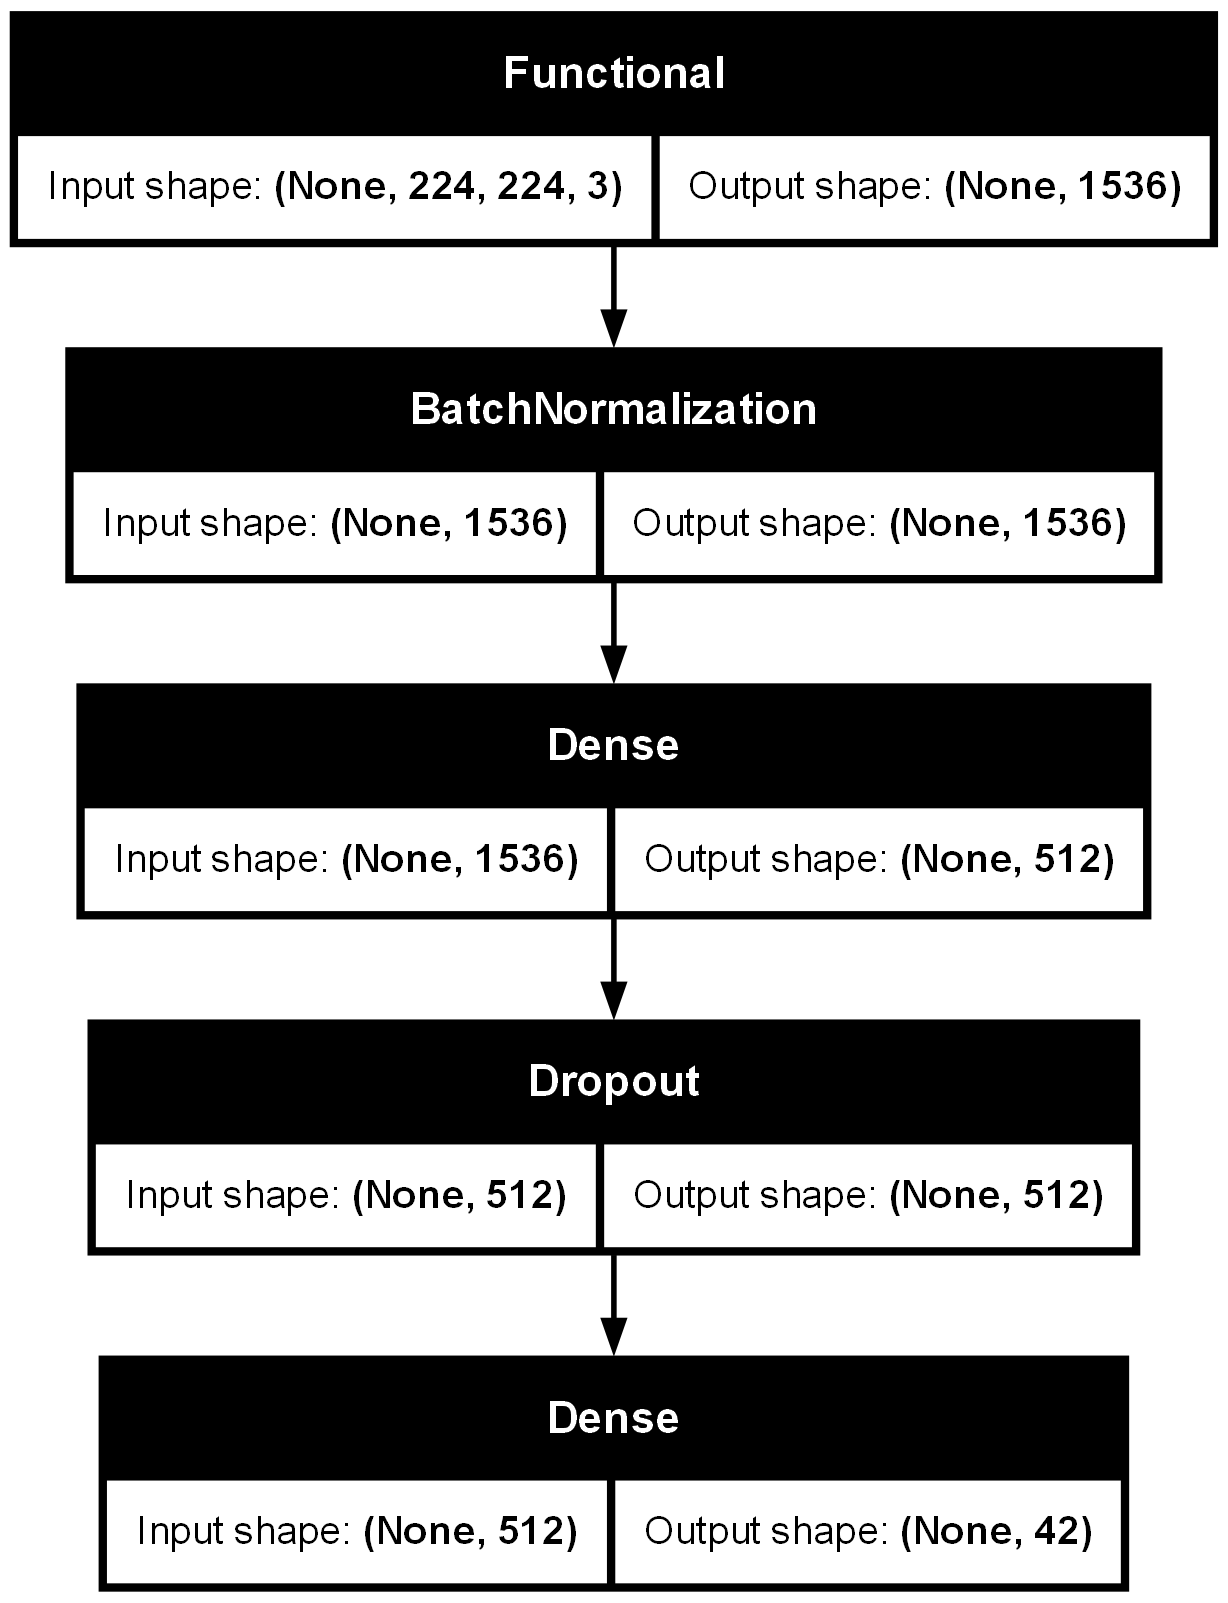

In [14]:

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/' 

image_file = "A:\\BSCS\\P\\Plot\\plot_model.png"
plot_model(model, to_file = image_file, show_shapes = True)

In [15]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = 20 # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training
    @property
    def model(self):
        return self._model

    @model.setter
    def model(self, value):
        self._model = value
        # callback variables
        self.count = 0  # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1  # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))  # get the initial learning rate and save it
        self.highest_tracc = 0.0  # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf  # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights()  # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()  # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch+1), str(self.params['steps']), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))  # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    current_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
                    lr = lr * self.factor  # adjust the learning rate by factor
                    self.model.optimizer.learning_rate.assign(lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                   


                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

                            early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
                            checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
  

In [16]:
model.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 42)                  │          21,546 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,598,169 (44.24 MB)

 Trainable params: 11,507,794 (43.90 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [17]:
batch_size = 40
epochs = 40
patience = 1
stop_patience = 3
threshold = 0.9
factor = 0.5
ask_epoch = 10
batches = int(np.ceil(len(train_df.labels) / batch_size))

callbacks = [MyCallback(model=model, patience=patience, stop_patience=20, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

In [18]:
history = model.fit(x= train_df, epochs= epochs, verbose=0, callbacks= callbacks,
                    validation_data= validation_df, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?


 y


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     2.910   30.359   3.05265  34.082   0.00100  0.00100  accuracy     0.00   3117.07 
 2 /40     1.503   59.323   1.56440  60.594   0.00100  0.00100  accuracy    95.40   2630.88 
 3 /40     1.006   71.432   1.26641  67.367   0.00100  0.00100  accuracy    20.41   2946.14 
 4 /40     0.792   76.879   1.30810  66.896   0.00100  0.00100  accuracy     7.63   2288.86 
 5 /40     0.708   79.788   1.22047  68.453   0.00100  0.00100  accuracy     3.78   2207.98 
 6 /40     0.590   82.984   1.10706  71.025   0.00100  0.00100  accuracy     4.01   2210.13 
 7 /40     0.565   83.470   1.07570  72.329   0.00100  0.00100  accuracy     0.59   2801.48 
 8 /40     0.550   83.848   1.20834  70.373   0.00100  0.00100  accuracy     0.45   2873.96 
 9 /40     0.554   84.163   1.31084  68.635   0.00100  0.00100  accuracy     0.38   2214.50 
10 /40     0.456   86.792   1.27152  70.916   0.00100  0.00100  accurac

 15


 training will continue until epoch 25
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
11 /40     0.501   85.748   1.14392  73.234   0.00100  0.00050  accuracy    -1.20   2939.76 
12 /40     0.246   92.491   0.77639  81.891   0.00050  0.00050  val_loss    27.82   2347.11 
13 /40     0.131   96.048   0.80100  81.021   0.00050  0.00025  val_loss    -3.17   2559.48 
14 /40     0.110   96.426   0.75492  82.506   0.00050  0.00050  val_loss     2.77   2946.01 
15 /40     0.147   95.516   0.94542  81.311   0.00050  0.00025  val_loss    -25.23  2221.81 
16 /40     0.184   94.508   0.83263  82.398   0.00050  0.00025  val_loss    -10.29  2220.29 
17 /40     0.107   96.624   0.94825  80.080   0.00050  0.00025  val_loss    -25.61  2223.17 
18 /40     0.168   94.967   0.89161  81.058   0.00050  0.00025  val_loss    -18.11  2228.43 
19 /40     0.124   96.300   0.88629  82.072   0.00050  0.00025  val_loss    -17.40  2220.94 
20 /40     0.113   96.534   0.85

 h


training has been halted at epoch 25 due to user input
training elapsed time was 17.0 hours, 23.0 minutes, 54.88 seconds)


In [19]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [20]:
model.compile(Adamax(learning_rate= 0.001), loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 42)                  │          21,546 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,598,169 (44.24 MB)

 Trainable params: 11,387,504 (43.44 MB)

 Non-trainable params: 210,665 (822.91 KB)

In [21]:
def train_model(model, train_data, val_data, epochs=50, batch_size=32, model_save_path='model.h5'):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    model_checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, verbose=1)

    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, reduce_lr, model_checkpoint])

    return history

In [22]:
ft_epoch = 1
n_epochs =+ ft_epoch
history_fine = model.fit(train_df, validation_data = (validation_df), epochs = 40, initial_epoch = history.epoch[-1])

Epoch 25/40
348/348 ━━━━━━━━━━━━━━━━━━━━ 1245s 3s/step - accuracy: 0.9706 - loss: 0.0882 - val_accuracy: 0.8396 - val_loss: 0.7610
Epoch 26/40
348/348 ━━━━━━━━━━━━━━━━━━━━ 1186s 3s/step - accuracy: 0.9855 - loss: 0.0469 - val_accuracy: 0.8414 - val_loss: 0.7411
Epoch 27/40
348/348 ━━━━━━━━━━━━━━━━━━━━ 1187s 3s/step - accuracy: 0.9890 - loss: 0.0333 - val_accuracy: 0.8544 - val_loss: 0.6815
Epoch 28/40
348/348 ━━━━━━━━━━━━━━━━━━━━ 1198s 3s/step - accuracy: 0.9905 - loss: 0.0331 - val_accuracy: 0.8526 - val_loss: 0.7151
Epoch 29/40
348/348 ━━━━━━━━━━━━━━━━━━━━ 1186s 3s/step - accuracy: 0.9907 - loss: 0.0324 - val_accuracy: 0.8580 - val_loss: 0.7153
Epoch 30/40
348/348 ━━━━━━━━━━━━━━━━━━━━ 1185s 3s/step - accuracy: 0.9939 - loss: 0.0200 - val_accuracy: 0.8544 - val_loss: 0.7252
Epoch 31/40
348/348 ━━━━━━━━━━━━━━━━━━━━ 1187s 3s/step - accuracy: 0.9951 - loss: 0.0162 - val_accuracy: 0.8584 - val_loss: 0.7166
Epoch 32/40
348/348 ━━━━━━━━━━━━━━━━━━━━ 1185s 3s/step - accuracy: 0.9959 - loss: 0

In [23]:
def train_model(model, train_data, val_data, epochs=50, batch_size=32, model_save_path='model.h5'):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    model_checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, verbose=1)

    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, reduce_lr, model_checkpoint])

    return history

In [24]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


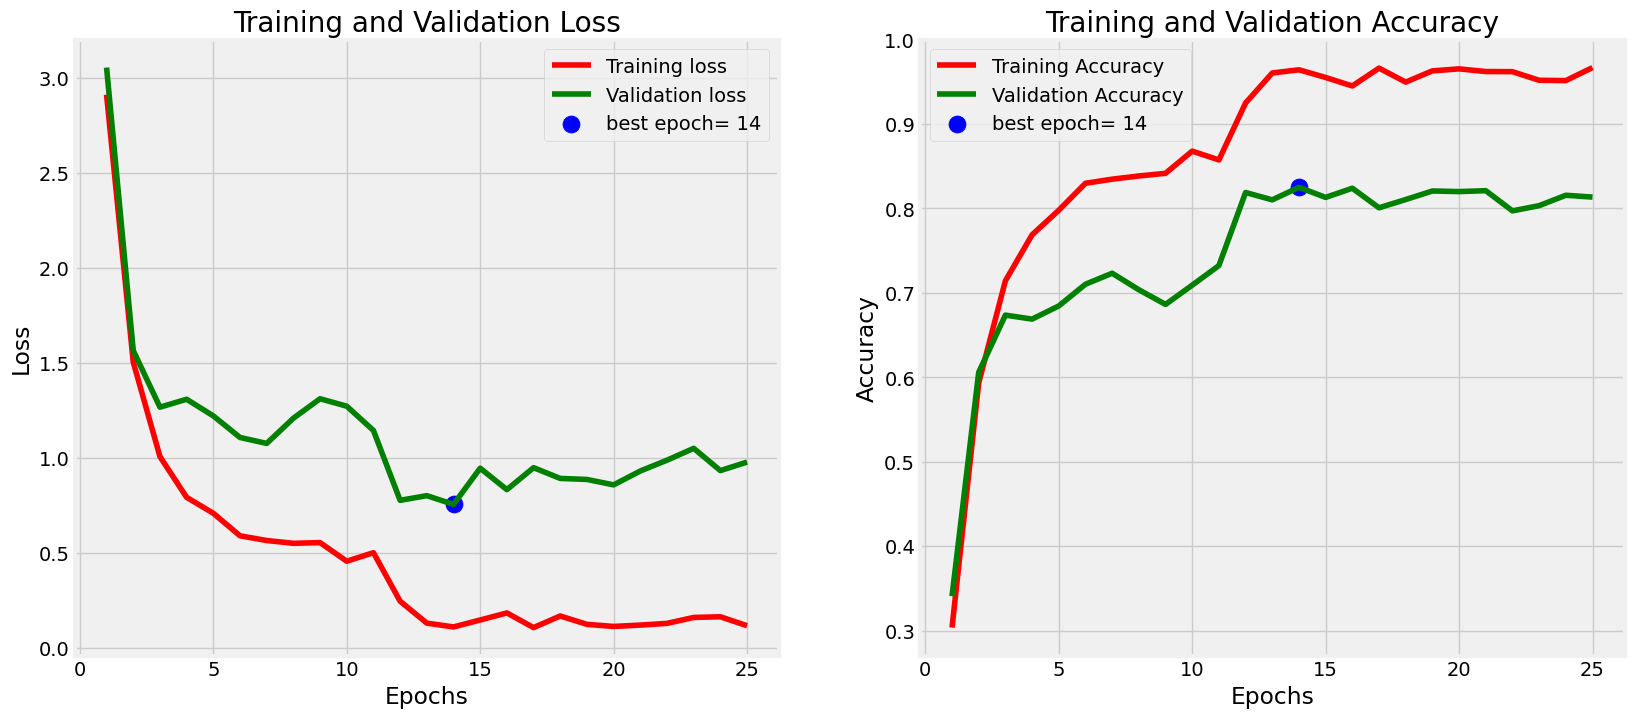

In [25]:
plot_training(history)

In [26]:
image_batch, label_batch = next(test_df)  # Using next() function
pred_labels = np.argmax(model.predict(image_batch), axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [61]:
test_dir = "A:/BSCS/P/Dataset/testing/"
test_data_path = pathlib.Path(test_dir)
batch_size=20;
seed=123;

testing_df = image_dataset_from_directory( test_data_path,
                                             image_size = (224, 224),
                                             shuffle = False,                                         
                                             batch_size = batch_size,
                                             seed = seed)
label = np.argmax(model.predict(testing_df), axis = 1)
ans = list()
for l in label:
    ans.append(class_names[l])
ans



Found 6 files belonging to 1 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


['F16', 'F16', 'B1', 'F117', 'Tornado', 'Rafale']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


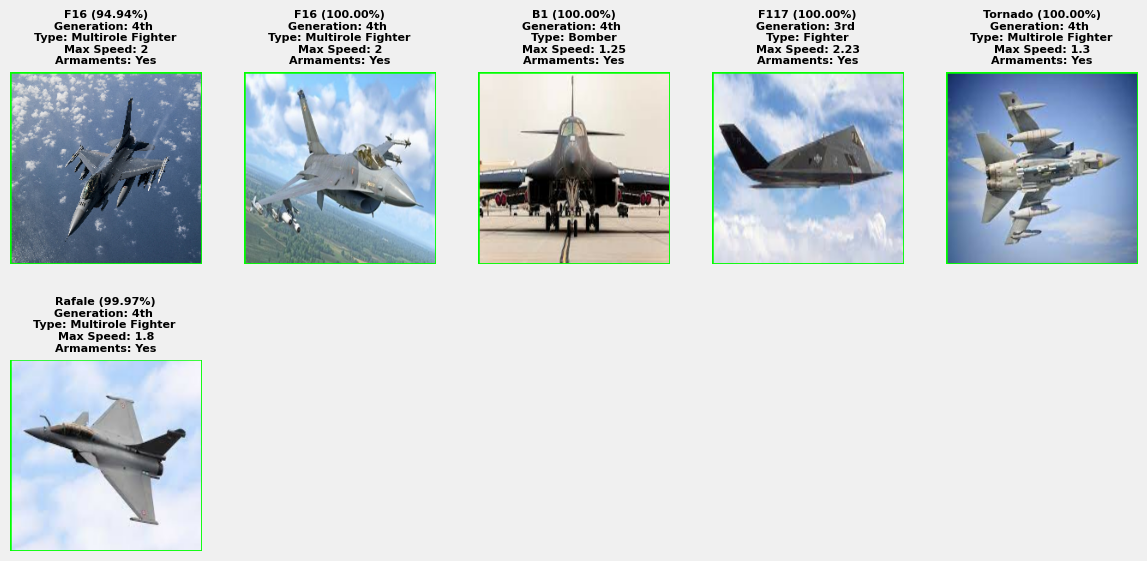

In [62]:
# Additional imports
from tensorflow.keras.preprocessing import image

# Define a function to add bounding boxes and display accuracy
def display_images_with_bounding_boxes(testing_df, model, class_names, plane_details):
    plt.figure(figsize=(13, 13))
    
    for images, labels in testing_df.take(1):
        for i in range(len(images)):
                img = images[i].numpy().astype("uint8")
                img_copy = img.copy()
                # Predict the class and its probability
                img_tensor = image.img_to_array(img)
                img_tensor = np.expand_dims(img_tensor, axis=0)
                prediction = model.predict(img_tensor)
                predicted_class = np.argmax(prediction, axis=1)
                predicted_class_name = class_names[predicted_class[0]]
                predicted_probability = np.max(prediction, axis=1)[0]
                
                # Add a bounding box (in this case, a rectangle around the entire image)
                cv2.rectangle(img_copy, (0, 0), (img_copy.shape[1], img_copy.shape[0]), (0, 255, 0), 2)
                
                # Display the image with the bounding box, accuracy, and plane details
                ax = plt.subplot(4, 5, i + 1)
                plt.subplots_adjust(wspace=0.2, hspace=0.5)
                plt.imshow(img_copy)
                plt.title(f"{predicted_class_name} ({predicted_probability * 100:.2f}%)\n{plane_details[predicted_class_name]}", fontsize=8,fontweight='bold')
                plt.axis("off")
       
# Call the function to display the images with bounding boxes, accuracy, and plane details
display_images_with_bounding_boxes(testing_df, model, class_names, plane_details)


In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

In [30]:
# Generating Numpy array with True classes' indexes
y_true = np.random.randint(low=0, high=len(class_names), size=100, dtype=int)


# Check point
# Shwoing array
print(y_true)

[32 40 24 13  8 14  6  1 30  6 40 10 12 12 25  7 13  1 41 14 23 33  3 17
 24 23  5 33 37  2 18 35 18 27  9 17  3 11 26 28 11 10  3 23 25 27  3 35
 14 21 23 23 36  4  5  9  2 37 33  5  9 15 28  2 10 36  3  3 23 27 34 37
 23 21 25 17  2 10  8 32 25 35  3  1  7  6 35 33 39 18 28 38  5  9 40 41
  4 23 40 21]


In [31]:
# Making copy of array with True classes' indexes
y_predicted = np.copy(y_true)

In [32]:
# Choosing randomly 25% of classes to be changed
ii = np.random.randint(low=0, high=len(y_true), size=int(0.25 * len(y_true)), dtype=int)


# Check point
# Showing chosen indexes
print(ii)

[89 50 36 44 92 99 83 81 61 14 78 23 62 28 80 24 15 49 80 84 90  4 21 32
 39]


In [33]:
# Iterating chosen indexes and replacing them with other classes' indexes
for i in ii:
    # Generating new class index
    y_predicted[i] = np.random.randint(low=0, high=len(class_names), dtype=int)
    
    
    # Check point
    # Showing difference between True classes' indexes and Predicted ones
    print('index = {0:2d}, True class => {1}, {2} <= Predicted class'.
          format(i, y_true[i], y_predicted[i]))

index = 89, True class => 18, 1 <= Predicted class
index = 50, True class => 23, 34 <= Predicted class
index = 36, True class => 3, 18 <= Predicted class
index = 44, True class => 25, 39 <= Predicted class
index = 92, True class => 5, 26 <= Predicted class
index = 99, True class => 21, 39 <= Predicted class
index = 83, True class => 1, 35 <= Predicted class
index = 81, True class => 35, 38 <= Predicted class
index = 61, True class => 15, 1 <= Predicted class
index = 14, True class => 25, 40 <= Predicted class
index = 78, True class => 8, 17 <= Predicted class
index = 23, True class => 17, 22 <= Predicted class
index = 62, True class => 28, 25 <= Predicted class
index = 28, True class => 37, 10 <= Predicted class
index = 80, True class => 25, 0 <= Predicted class
index = 24, True class => 24, 35 <= Predicted class
index = 15, True class => 7, 19 <= Predicted class
index = 49, True class => 21, 30 <= Predicted class
index = 80, True class => 25, 7 <= Predicted class
index = 84, True clas

In [34]:
# Ensure all classes are represented in y_true and y_predicted
for i in range(len(class_names)):
    if i not in y_true:
        y_true[np.random.randint(len(y_true))] = i
    if i not in y_predicted:
        y_predicted[np.random.randint(len(y_predicted))] = i

In [35]:
# Confusion Matrix is a two dimensional matrix that visualizes the performance,
# and makes it easy to see confusion between classes,
# by providing a picture of interrelation

# Each row represents a number of actual, True class
# Each column represents a number of predicted class


# Computing Confusion Matrix to evaluate accuracy of classification
c_m = confusion_matrix(y_true, y_predicted)

# Showing Confusion Matrix in form of 2D Numpy array
print(c_m)

[[0 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [1 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]


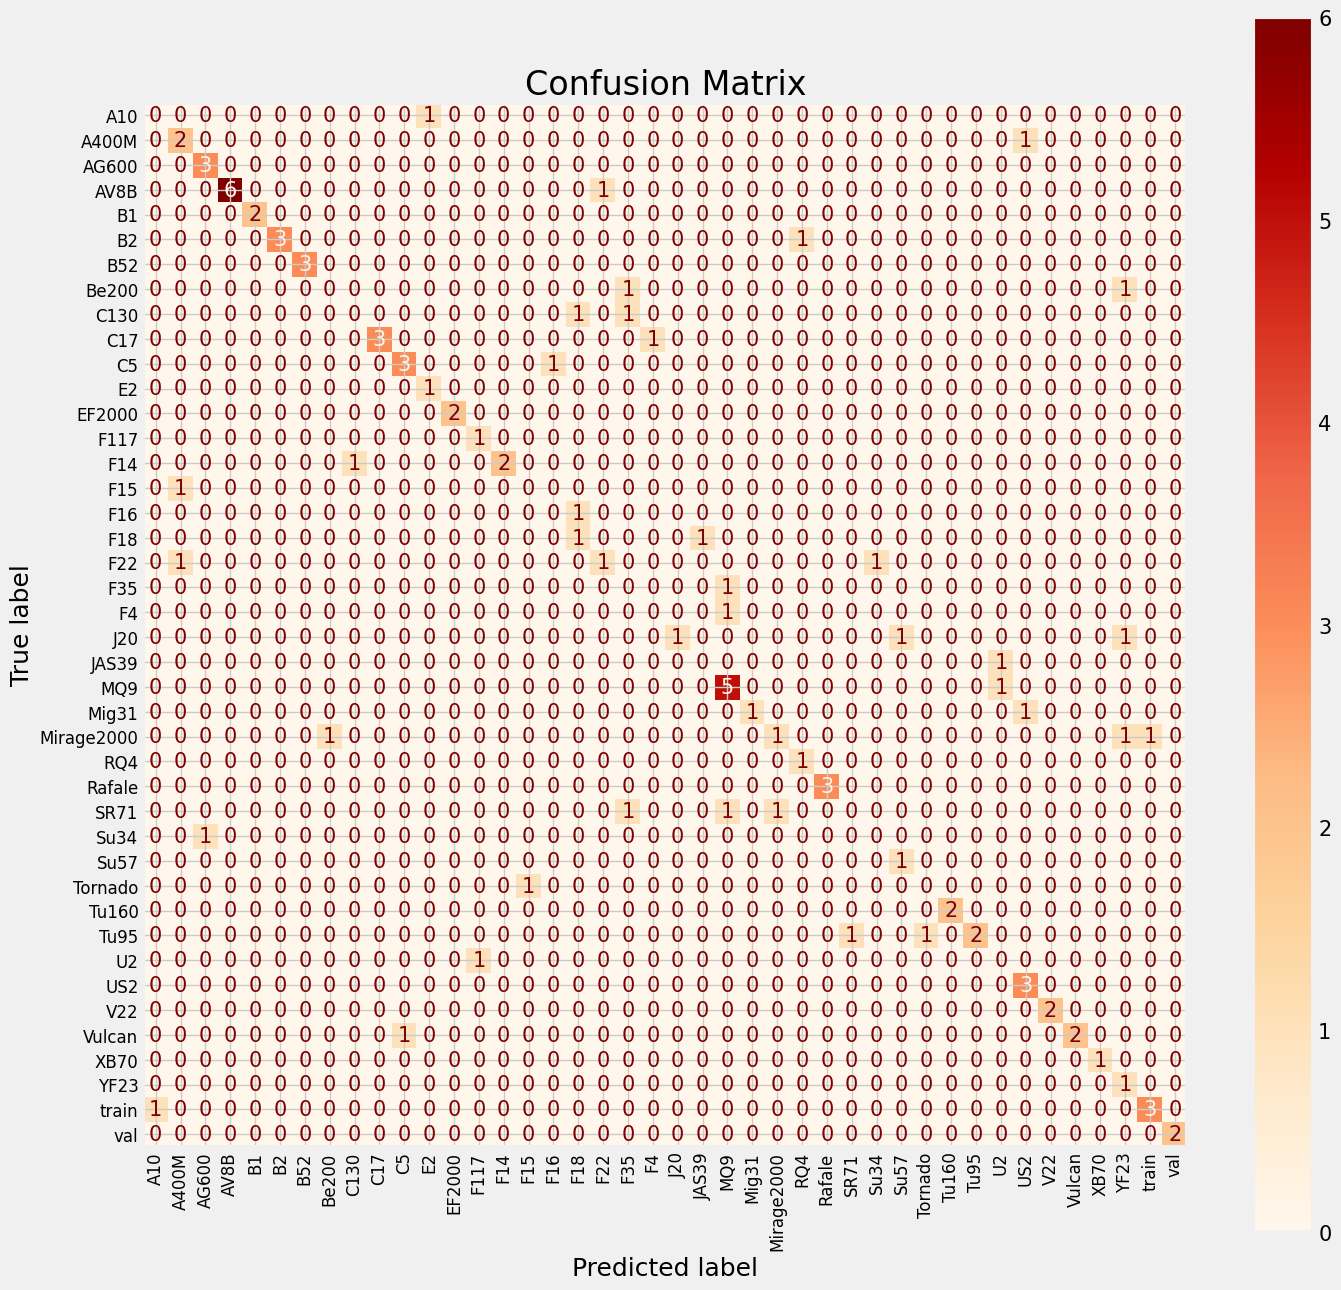

In [36]:
# Magic function that renders the figure in a jupyter notebook
# instead of displaying a figure object
%matplotlib inline

# Setting default size of the plot
# Setting default fontsize used in the plot
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.rcParams['font.size'] = 15


# Implementing visualization of Confusion Matrix
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=class_names)


# Plotting Confusion Matrix
# Setting colour map to be used
display_c_m.plot(cmap='OrRd', xticks_rotation=90)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Setting fontsize for xticks and yticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Giving name to the plot
plt.title('Confusion Matrix', fontsize=24)


# Saving plot
plt.savefig('confusion_matrix.png', transparent=True, dpi=300)


# Showing the plot
plt.show()


In [37]:
import itertools
# Use model.predict instead of predict_generator
preds = model.predict(test_df)
y_pred = np.argmax(preds, axis=1)
print(y_pred)


87/87 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step
[27  0  0 ... 39 39 39]


In [38]:
model.export('A:/BSCS/P/Dataset/train data/save2')

INFO:tensorflow:Assets written to: A:/BSCS/P/Dataset/train data/save2\assets


INFO:tensorflow:Assets written to: A:/BSCS/P/Dataset/train data/save2\assets


Saved artifact at 'A:/BSCS/P/Dataset/train data/save2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_386')
Output Type:
  TensorSpec(shape=(None, 42), dtype=tf.float32, name=None)
Captures:
  1733628308048: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1733628306704: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1733628306128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1733628306320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1733628307856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1733628305552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1733628304208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1733628311696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1733633098192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1733633099344: TensorSpec(shape=(), dtype=tf.resource, name=N

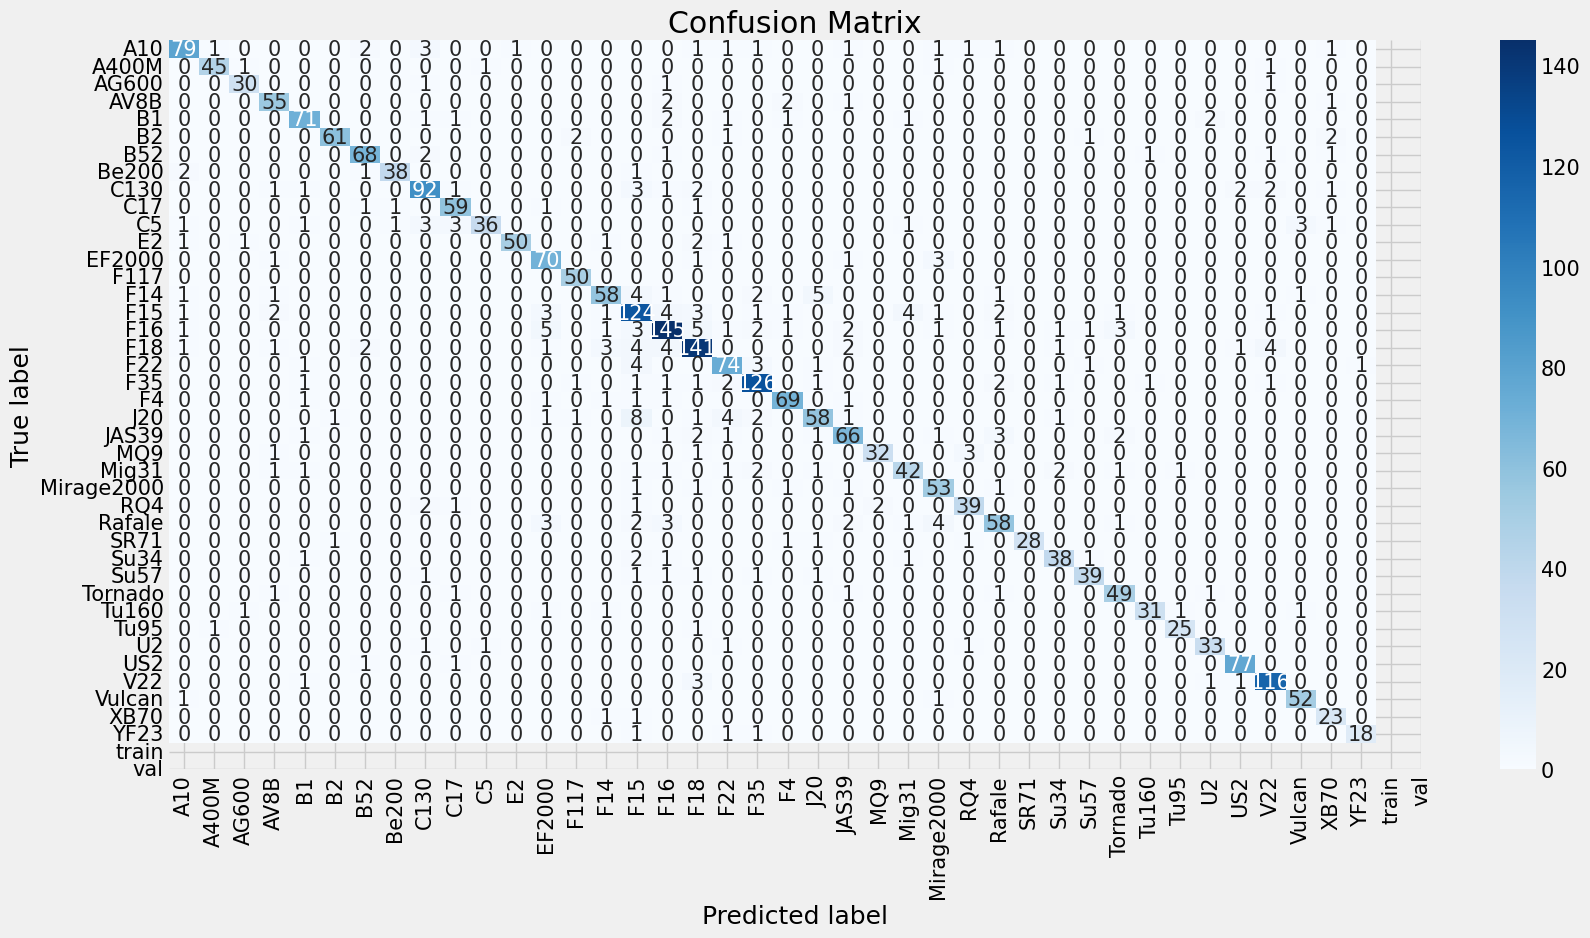

              precision    recall  f1-score   support

         A10       0.00      0.00      0.00         0
       A400M       0.00      0.00      0.00         0
       AG600       0.00      0.00      0.00         0
        AV8B       0.00      0.00      0.00         0
          B1       0.00      0.00      0.00         0
          B2       0.00      0.00      0.00         0
         B52       0.00      0.00      0.00         0
       Be200       0.00      0.00      0.00         0
        C130       0.00      0.00      0.00         0
         C17       0.00      0.00      0.00         0
          C5       0.00      0.00      0.00         0
          E2       0.00      0.00      0.00         0
      EF2000       0.00      0.00      0.00         0
        F117       0.00      0.00      0.00         0
         F14       0.00      0.00      0.00         0
         F15       0.00      0.00      0.00         0
         F16       0.00      0.00      0.00         0
         F18       0.00    

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming g_dict and y_pred are already defined
g_dict = test_df.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_df.classes, y_pred)

# Plot confusion matrix using seaborn
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(18, 9))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')

# Ensure the dimensions of y_true and y_pred are correct
assert len(test_df.classes) == len(y_pred), "Dimensions of y_true and y_pred do not match."

# Classification report with explicit labels parameter
print(classification_report(test_df.classes, y_pred, labels=classes))


In [63]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [64]:
model.export('A:/BSCS/P/Dataset/train data/finalsave')

INFO:tensorflow:Assets written to: A:/BSCS/P/Dataset/train data/finalsave\assets


INFO:tensorflow:Assets written to: A:/BSCS/P/Dataset/train data/finalsave\assets


Saved artifact at 'A:/BSCS/P/Dataset/train data/finalsave'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_386')
Output Type:
  TensorSpec(shape=(None, 42), dtype=tf.float32, name=None)
Captures:
  1733628308048: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1733628306704: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1733628306128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1733628306320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1733628307856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1733628305552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1733628304208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1733628311696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1733633098192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1733633099344: TensorSpec(shape=(), dtype=tf.resource, na

In [65]:
model.save('A:/BSCS/P/Dataset/train data/finalsave.keras')

In [66]:
model.save('A:/BSCS/P/Dataset/train data/finalsave.h5')

In [68]:
import pickle

# Assuming your trained model is stored in a variable called 'model'

# Save the model to a file
with open('newmodel.sav', 'wb') as file:
    pickle.dump(model, file)



## Load the model from the file
#with open('model.pkl', 'rb') as file:
#    loaded_model = pickle.load(fi#
## Use the loaded model for predictions or other tasks
#predictions = loaded_model.predict()